Setup

In [67]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ml-predict-firewall-actions"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Read the Dataset

In [68]:
import pandas as pd

df = pd.read_csv('internet-firewall-data.csv')

df

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0


Move 'Action' column to last column

In [69]:
column_to_move = 'Action'

new_column_order = [col for col in df.columns if col != column_to_move] + [column_to_move]

df = df[new_column_order]
df2 = df
df

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action
0,57222,53,54587,53,177,94,83,2,30,1,1,allow
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,allow
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,allow
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,allow
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,allow
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,314,192,122,6,15,4,2,allow
65528,50964,80,13485,80,4680740,67312,4613428,4675,77,985,3690,allow
65529,54871,445,0,0,70,70,0,1,0,1,0,drop
65530,54870,445,0,0,70,70,0,1,0,1,0,drop


Discover and Visualize the data to gain insights

In [70]:
internet_data = df

internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Bytes                 65532 non-null  int64 
 5   Bytes Sent            65532 non-null  int64 
 6   Bytes Received        65532 non-null  int64 
 7   Packets               65532 non-null  int64 
 8   Elapsed Time (sec)    65532 non-null  int64 
 9   pkts_sent             65532 non-null  int64 
 10  pkts_received         65532 non-null  int64 
 11  Action                65532 non-null  object
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [71]:
internet_data["Action"].value_counts()

Action
allow         37640
deny          14987
drop          12851
reset-both       54
Name: count, dtype: int64

In [72]:
internet_data.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [73]:
df['Action'] = df['Action'].astype('category').cat.codes
correlation_matrix1 = df.corr(method='pearson')
correlation_matrix1

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action
Source Port,1.000000,-0.332246,0.145391,-0.024843,0.000221,-0.000931,0.001950,-0.001742,-0.046515,-0.001422,-0.001962,0.038343
Destination Port,-0.332246,1.000000,-0.281676,0.410042,-0.005297,0.001675,-0.014684,-0.006063,0.023537,-0.002134,-0.010909,0.095110
NAT Source Port,0.145391,-0.281676,1.000000,0.178435,0.010659,0.002242,0.020827,0.012633,0.141485,0.007180,0.018772,-0.686893
NAT Destination Port,-0.024843,0.410042,0.178435,1.000000,0.003975,0.007904,-0.003216,0.004605,0.219776,0.006136,0.001747,-0.214765
Bytes,0.000221,-0.005297,0.010659,0.003975,1.000000,0.933462,0.830225,0.974379,0.148834,0.966548,0.850209,-0.013546
Bytes Sent,-0.000931,0.001675,0.002242,0.007904,0.933462,1.000000,0.575047,0.887596,0.126039,0.973976,0.639098,-0.004570
Bytes Received,0.001950,-0.014684,0.020827,-0.003216,0.830225,0.575047,1.000000,0.843067,0.143601,0.690959,0.946039,-0.023794
Packets,-0.001742,-0.006063,0.012633,0.004605,0.974379,0.887596,0.843067,1.000000,0.147074,0.961286,0.916978,-0.015562
Elapsed Time (sec),-0.046515,0.023537,0.141485,0.219776,0.148834,0.126039,0.143601,0.147074,1.000000,0.135101,0.143954,-0.170684
pkts_sent,-0.001422,-0.002134,0.007180,0.006136,0.966548,0.973976,0.690959,0.961286,0.135101,1.000000,0.771550,-0.009842


In [74]:
# Convert the Action column from categorical to numerial with one-hot encoding
df_one_hot = pd.get_dummies(df2, columns=['Action'])

# Calculate Pearson correlation
correlation_matrix2 = df_one_hot.corr(method='pearson')
correlation_matrix2

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action_0,Action_1,Action_2,Action_3
Source Port,1.000000,-0.332246,0.145391,-0.024843,0.000221,-0.000931,0.001950,-0.001742,-0.046515,-0.001422,-0.001962,0.132189,-0.386728,0.247548,-0.042674
Destination Port,-0.332246,1.000000,-0.281676,0.410042,-0.005297,0.001675,-0.014684,-0.006063,0.023537,-0.002134,-0.010909,-0.367960,0.687862,-0.271009,0.022247
NAT Source Port,0.145391,-0.281676,1.000000,0.178435,0.010659,0.002242,0.020827,0.012633,0.141485,0.007180,0.018772,0.754348,-0.477127,-0.433486,-0.016482
NAT Destination Port,-0.024843,0.410042,0.178435,1.000000,0.003975,0.007904,-0.003216,0.004605,0.219776,0.006136,0.001747,0.235859,-0.149221,-0.135458,-0.005655
Bytes,0.000221,-0.005297,0.010659,0.003975,1.000000,0.933462,0.830225,0.974379,0.148834,0.966548,0.850209,0.014869,-0.009405,-0.008532,-0.000496
Bytes Sent,-0.000931,0.001675,0.002242,0.007904,0.933462,1.000000,0.575047,0.887596,0.126039,0.973976,0.639098,0.005017,-0.003172,-0.002879,-0.000167
Bytes Received,0.001950,-0.014684,0.020827,-0.003216,0.830225,0.575047,1.000000,0.843067,0.143601,0.690959,0.946039,0.026119,-0.016522,-0.014986,-0.000871
Packets,-0.001742,-0.006063,0.012633,0.004605,0.974379,0.887596,0.843067,1.000000,0.147074,0.961286,0.916978,0.017083,-0.010806,-0.009802,-0.000566
Elapsed Time (sec),-0.046515,0.023537,0.141485,0.219776,0.148834,0.126039,0.143601,0.147074,1.000000,0.135101,0.143954,0.187367,-0.118522,-0.107503,-0.006238
pkts_sent,-0.001422,-0.002134,0.007180,0.006136,0.966548,0.973976,0.690959,0.961286,0.135101,1.000000,0.771550,0.010804,-0.006834,-0.006199,-0.000356


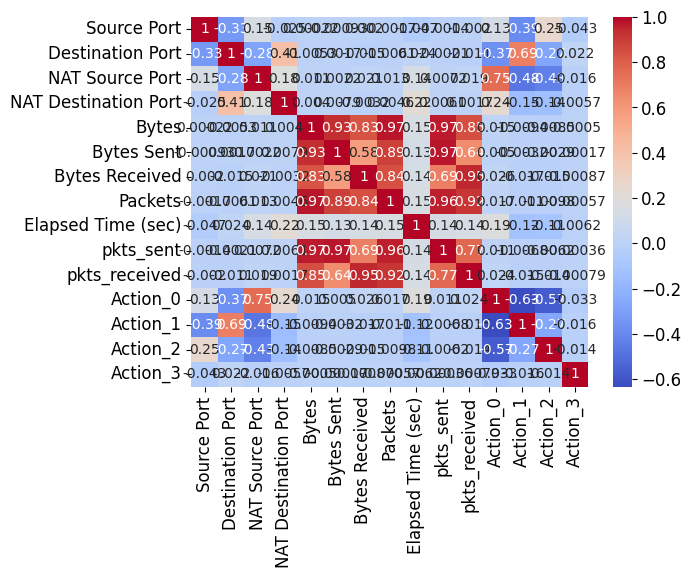

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm')

plt.show()